In [58]:
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from flask import Flask, jsonify
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
engine = create_engine("sqlite:///Resources/Hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)
Station = Base.classes.station
Measure = Base.classes.measurement
session = Session(engine)
#conn = engine.connect()

In [3]:
sql=f"select date,prcp from measurement where CAST((julianday('now') - julianday(date)) / 30 AS integer) < 24"
prcp_df = pd.read_sql(sql, engine, index_col="date")

In [4]:
prcp_df.head()

,prcp
date,
2016-05-26,0.06
2016-05-27,0.00
2016-05-28,0.10
2016-05-29,0.54
2016-05-30,0.16


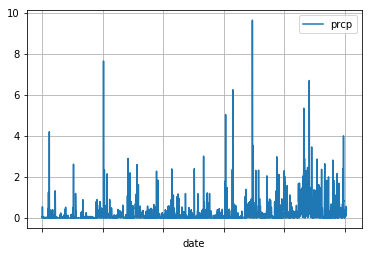

In [5]:
#prcp_df.plot(kind='bar', stacked=True, width=10,color="#9b59b6")
xvalue=('2010-01-01','2011-01-01','2012-01-01')
prcp_df.plot(grid=True,legend=True)

#f, ax = plt.subplots(figsize=(6, 15))
#sns.plot(x="date",y="prcp", data=prcp_df,  label="Precipitation", color="b")
#ns.pairplot(prcp_df)





In [6]:
from sqlalchemy import distinct

#to calculate the total number of stations.
# from station table
print(session.query(func.count(Station.station).label('Total')).first())

#From measurement table
session.query(func.count(distinct(Measure.station))).first()


(9,)


(9)

In [7]:
#List the stations and observation counts in descending order
total_stations=session.query(Measure.station,func.count(Measure.station).label('Observation')).\
        group_by(Measure.station).order_by('Observation DESC')
for stat in total_stations:
    print(stat.station,stat.Observation)

USC00519281 2772
USC00513117 2696
USC00519397 2685
USC00519523 2572
USC00516128 2484
USC00514830 1937
USC00511918 1932
USC00517948 683
USC00518838 342


C:\Users\achole\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sqlalchemy\sql\compiler.py:643: SAWarning: Can't resolve label reference 'Observation DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


In [27]:
#Which station has the highest number of observations?
most_ob_station=session.query(Measure.station,func.count(Measure.station).label('Observation')).\
        group_by(Measure.station).order_by('Observation DESC').first()
print(most_ob_station)

('USC00519281', 2772)


C:\Users\achole\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sqlalchemy\sql\compiler.py:643: SAWarning: Can't resolve label reference 'Observation DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


In [9]:
max_date_tuple=session.query(func.max(Measure.date).label('max_date')).\
        filter(Measure.station=='USC00519281').first()
    
start_date=max_date_tuple[0]-dt.timedelta(days=365)


In [54]:
#sql=f"select date,prcp from measurement where station='USC00519281' and date >={start_date}"
sql=f"select date,prcp from measurement where station='USC00519281' and date >=(select date(max(date),'-365 day') from measurement where station='USC00519281')"

prcp_df = pd.read_sql(sql, engine, index_col="date")

In [55]:
prcp_df.head()

,prcp
date,
2016-08-18,0.00
2016-08-19,0.31
2016-08-20,0.13
2016-08-21,0.08
2016-08-22,2.32


Text(0,0.5,'Prcp')

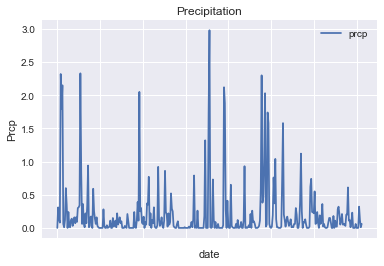

In [69]:
ax=prcp_df.plot(grid=True)
ax.set_title("Precipitation")
ax.set_ylabel("Prcp")

In [40]:
sql=f"select * from measurement where station='USC00519281' and date >=(select date(max(date),'-365 day') from measurement where station='USC00519281')"
tobs_df = pd.read_sql(sql, engine)


In [41]:
tobs_df.head()

,id,station,date,prcp,tobs
0,13330,USC00519281,2016-08-18,0.00,80.0
1,13331,USC00519281,2016-08-19,0.31,79.0
2,13332,USC00519281,2016-08-20,0.13,81.0
3,13333,USC00519281,2016-08-21,0.08,79.0
4,13334,USC00519281,2016-08-22,2.32,78.0


[Text(0,0.5,'Frequency')]

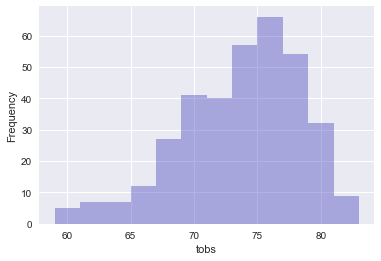

In [65]:
sns.set(style="darkgrid")
ax= sns.distplot(tobs_df['tobs'],bins=12,kde=False,label="tobas", color=sns.desaturate('blue',0.5))
ax.set(ylabel='Frequency')


In [71]:
def calc_temps(st_dt,end_dt):
    sel = [func.min(Measure.tobs).label('TMIN'), 
       func.max(Measure.tobs).label('TMAX'), 
       func.avg(Measure.tobs).label('TAVG')]
    start_date = dt.datetime.strptime(st_dt , '%Y-%m-%d')-dt.timedelta(days=1)
    end_date = dt.datetime.strptime(end_dt , '%Y-%m-%d')
    return session.query(*sel).filter(Measure.date >=start_date).filter(Measure.date<=end_date).first()


In [72]:
get_trip_temp=calc_temps("2010-01-01","2010-02-01")

[Text(0,0.5,'Temp (F)')]

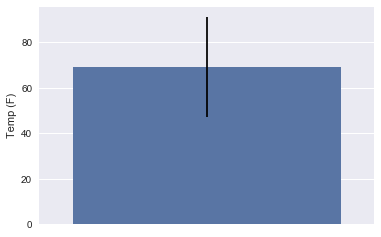

In [78]:
sns.set(style="darkgrid")
#ax= sns.distplot(tobs_df['tobs'],bins=12,kde=False,label="tobas", color=sns.desaturate('blue',0.5))
ax.set(ylabel='Frequency')
ax = sns.barplot(y=get_trip_temp[2],yerr=get_trip_temp[1]-get_trip_temp[0])
ax.set(ylabel='Temp (F)')
